In [21]:
import os
import sys
import cv2 as cv
import numpy as np
import time
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import data, filters, morphology
from skimage.measure import shannon_entropy
from scipy.spatial import distance as sc_distance
from skimage.feature import peak_local_max, canny
from skimage.segmentation import watershed
import torch
import torchvision.ops.boxes as bops
src_path = os.path.abspath(os.path.join(os.path.abspath(''), '../'))
sys.path.append(src_path)
import blob_class as bc
import blob_detection as bd
import contrast_functions as cf

In [22]:
def blob_nuclei(image, min_percent_area=10):
    """
    Finds cell nuclei in an image

    Parameters
    ----------
    image : image matrix
        input image

    min_percent_area : int or float
        Minimum percent of image area to be considered
        an actual nuclei

    Returns
    -------
    blob_nuclei: list of Blob objects
        A list of blob nuclei found in image
    """

    # find edges in the image
    edges = filters.sobel(image)
    edges = cf.percentile_rescale(edges, 0.35, 99.65)

    # make binary image
    thresh = filters.threshold_li(edges)
    _ , im_binary = cv.threshold(edges, thresh, 255, cv.THRESH_BINARY)
    
    # find and sort contours by area - largest first
    contours, _ = cv.findContours(im_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    
    # find min_area
    shape = im_gray.shape
    ax1 = shape[0] * min_percent_area / 100
    ax2 = shape[1] * min_percent_area / 100
    min_area = ax1 * ax2
    
    # get blob_nuclei which are above correct size
    # have to make Blob object to get pixel area
    blob_nuclei = []
    for cont in contours:
        # create Blob object
        blob = bc.Blob(cont, image)

        # append blob if large enough
        if blob.area_filled > min_area:
            blob_nuclei.append(blob)

        # else break as next blob would be smaller
        else:
            break
        
    return blob_nuclei
        
#blob_contours = blob_nuclei(im_blur)
#print(len(blob_contours))
#print(blob_contours)

In [23]:
def get_maxima(image, distance=5, threshold=0.75):

    if isinstance(image, np.ndarray):
        if image.ndim > 2:
            image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

        local_max_thresh = np.mean(image) * threshold
        local_max_coords = peak_local_max(image,
                                          min_distance=distance,
                                          threshold_abs=local_max_thresh)
        local_max_coords = [[x, y] for y, x in local_max_coords]  # y,x -> x,y
        return local_max_coords

    elif isinstance(image, bc.Blob):
        local_max_thresh = image.pixel_intensity_percentile(threshold * 100)
        local_max_coords = peak_local_max(image.image_masked,
                                          min_distance=distance,
                                          threshold_abs=local_max_thresh)
        local_max_coords = [[x, y] for y, x in local_max_coords]  # y,x -> x,y
        return local_max_coords

    else:
        raise TypeError('image must be numpy array or Blob instance')
    

In [24]:
def maxima_filter(contour, local_maxima):

    if len(local_maxima) == 0:
        return None, None
    # points is list of booleans
    # True in each index that maxima is inside contour
    points = np.array([cv.pointPolygonTest(np.array(contour),
                                           (int(maxima[0]), int(maxima[1])),
                                           False)
                       for maxima in local_maxima])

    if np.sum(points == 1) >= 1:  # if maxima found
        idxs = np.where(points == 1)  # points are true
        maxima = np.array(local_maxima)[idxs]
        return maxima, idxs[0]

    # return None if no maxima found
    return None, None

In [25]:
def get_contours(image, min_length=5, thresh_min=0, thresh_max=255, thresh_step=10):
    # may want to calculate min_length (perimeter) based on min area of circle
    
    im = image.copy()
    im_thresh = []
    for i in range(thresh_max, thresh_min, -thresh_step):
        im[im >= i] = 0
        im_thresh.append(cv.threshold(im, 0.5, 255, cv.THRESH_BINARY)[1])

    all_contours = []
    maxima = []
    for thresh in im_thresh:
        contours, hierarchy = cv.findContours(thresh,
                                        cv.RETR_CCOMP,
                                        cv.CHAIN_APPROX_NONE)
        #hierachy = np.array(hierarchy[0])
        if hierarchy is not None:
            hierarchy = hierarchy[0]
            for i, row in enumerate(hierarchy):
                if len(contours[i]) >= min_length:
                    if row[2] == -1 and row[3] != -1:
                        all_contours.append(contours[i])
                        pts, idxs = maxima_filter(contours[i], maxima)
                        if idxs is None:
                            new_maxima = np.mean(contours[i], axis=0)[0].astype(int)
                            maxima.append(new_maxima)

    return all_contours, maxima

In [26]:
def segment_contours(binary_image, coords=None, num_peaks=None, min_distance=3):

    # apply distance transform
    distance = ndi.distance_transform_edt(binary_image)

    if coords is None and num_peaks is None:
        coords = peak_local_max(distance,
                                threshold_rel=0.5,
                                min_distance=min_distance,
                                footprint=np.ones((3, 3)),
                                labels=binary_image)
    
    elif coords is None:
        coords = peak_local_max(distance,
                                threshold_rel=0.5,
                                num_peaks=num_peaks,
                                min_distance=min_distance,
                                footprint=np.ones((3, 3)),
                                labels=binary_image)
    
    else:
        coords = np.array([[y, x] for x,y in coords])
    
    # create mask with coords
    #coords = np.array([[y, x] for x,y in coords])
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True

    # perform watershed segmentation
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=binary_image)
    #plt.imshow(labels)
    
    # get contours of labeled points
    contours = []
    for i in range(1, np.max(labels)+1):
        binary = np.zeros(labels.shape, dtype="uint8")
        binary[np.where(labels == i)] = 255
        contour, _ = cv.findContours(binary,
                                     cv.RETR_EXTERNAL,
                                     cv.CHAIN_APPROX_NONE)
        if len(contour) > 0:
            contours.append(contour[0])

    return contours

In [27]:
def organize_contours(contours, coords): #image): #min_distance):

    # initalize empty list that will hold contours
    contour_list = [[] for pt in coords]
    contours_later = []

    # initalize list that contains index of points in contour_list
    # unique_points will contain single point idxs (ex. [2]) and
    # multiple point idxs (ex. [2, 5]) in case a contour always
    # contains multiple maxima
    unique_points = [[i] for i in range(len(coords))]

    # for each original contour found
    for contour in contours:
        maxima, idxs = maxima_filter(contour, coords)
        if idxs is not None:

            # if contour contains one maxima, append to idx in list
            if len(idxs) == 1:
                contour_list[idxs[0]].append(contour)

            # if contour contains more than one maxima, segment
            else:
                contours_later.append(contour) # ADD BACK FULL CONTOURS LATER
                
                # segment contour
                zeros_size = [np.max(contour)] * 2
                seg_binary = np.zeros(zeros_size, dtype="uint8")
                cv.fillPoly(seg_binary, pts=[contour], color=(255, 255, 255))
                seg_contours = segment_contours(seg_binary, num_peaks=len(maxima))#coords=maxima)

                # for each segmented contour
                for sc in seg_contours:
                    sc_maxima, sc_idxs = maxima_filter(sc, coords)
                    if sc_idxs is not None:
                        
                        # if all maxima are the same, append full contour
                        if len(idxs) == len(sc_idxs):
                            # new point (multiple idxs)
                            sc_idxs = list(sc_idxs)

                            # if new point not already in unqiue_points,
                            # add to unique_points and
                            # add empty list to contour_list
                            if sc_idxs not in unique_points:
                                unique_points.append(sc_idxs)
                                contour_list.append([])

                            # get index and add new cnt to contour_list
                            sc_idx = unique_points.index(sc_idxs)
                            contour_list[sc_idx].append(contour) 
                        
                        # if segmented contour doesn't contain all idxs,
                        # and doesn't overlap previous contours of the other
                        # maxima, append to idx in list
                        elif len(idxs) != len(sc_idxs): #else:
                            #Find all single and multi-point contours that could have
                            #potential overlap
                            cnts_query = []
                            # all idx in idxs that are not in sc_idxs
                            qry_idxs = [idx for idx in idxs if idx not in sc_idxs]
                            for i in range(len(unique_points)):
                                # determine if qry_idxs intersect with unique_points
                                if len(set(qry_idxs).intersection(unique_points[i])) > 0:
                                    try:
                                        cnts_query.append(contour_list[i][-1])
                                    except:
                                        None
                            
                            # determine if cnt overlaps any previous cnts
                            cnt_overlap = np.any([contour_intersect(sc, cnts_query[i])
                                                  for i in range(len(cnts_query))])
                            
                            # append cnt to list if no overlap
                            if cnt_overlap is False: 
                                # new point (multiple idxs)
                                sc_idxs = list(sc_idxs)

                                # if new point not already in unqiue_points,
                                # add to unique_points and
                                # add empty list to contour_list
                                if sc_idxs not in unique_points:
                                    unique_points.append(sc_idxs)
                                    contour_list.append([])

                                # get index and add new blob to contour_list
                                sc_idx = unique_points.index(sc_idxs)
                                contour_list[sc_idx].append(sc) 

    print(unique_points)
                            
    return contour_list

In [28]:
def best_contours(contours):
    
    # initalize list for best contours
    best_conts = []

    for i in range(len(contours)):
        if len(contours[i]) > 0:

            # find means of each contour for each maxima
            mean_list = []
            for cont in contours[i]:
                pts = np.array([[pt[0][1], pt[0][0]] for pt in cont])
                edge_mean = np.mean(edges[tuple(pts.T)])
                mean_list.append(edge_mean)

            # append contour with highest edge_mean to best_conts list
            max_idx = np.argmax(mean_list)
            best_conts.append(contours[i][max_idx])
            
    return best_conts

In [29]:
def contour_intersect(cnt_ref, cnt_query):
    ### Thanks to Pietro Cicalese on Stack Exchange
    ## Contours are both an np array of points
    ## Check for bbox intersection, then check pixel intersection if bboxes intersect

    # first check if it is possible that any of the contours intersect
    x1, y1, w1, h1 = cv.boundingRect(cnt_ref)
    x2, y2, w2, h2 = cv.boundingRect(cnt_query)
    # get contour areas
    area_ref = cv.contourArea(cnt_ref)
    area_query = cv.contourArea(cnt_query)
    # get coordinates as tensors
    box1 = torch.tensor([[x1, y1, x1 + w1, y1 + h1]], dtype=torch.float)
    box2 = torch.tensor([[x2, y2, x2 + w2, y2 + h2]], dtype=torch.float)
    # get bbox iou
    iou = bops.box_iou(box1, box2)

    if iou == 0:
        # bboxes dont intersect, so contours dont either
        return False
    else:
        # bboxes intersect, now check pixels
        # get the height, width, x, and y of the smaller contour
        if area_ref >= area_query:
            h = h2
            w = w2
            x = x2
            y = y2
        else:
            h = h1
            w = w1
            x = x1
            y = y1

        # get a canvas to draw the small contour and subspace of the large contour
        contour_canvas_ref = np.zeros((h, w), dtype='uint8')
        contour_canvas_query = np.zeros((h, w), dtype='uint8')
        # draw the pixels areas, filled (can also be outline)
        cv.drawContours(contour_canvas_ref, [cnt_ref], -1, 255, thickness=cv.FILLED,
                         offset=(-x, -y))
        cv.drawContours(contour_canvas_query, [cnt_query], -1, 255, thickness=cv.FILLED,
                         offset=(-x, -y))

        # check for any pixel overlap
        return np.any(np.bitwise_and(contour_canvas_ref, contour_canvas_query))
    

In [30]:
def contour_full_overlap(cnt_ref, cnt_qry):
    
    # first check if it is possible that any of the contours intersect
    x1, y1, w1, h1 = cv.boundingRect(cnt_ref)
    x2, y2, w2, h2 = cv.boundingRect(cnt_qry)

    # get coordinates as tensors
    box1 = torch.tensor([[x1, y1, x1 + w1, y1 + h1]], dtype=torch.float)
    box2 = torch.tensor([[x2, y2, x2 + w2, y2 + h2]], dtype=torch.float)
    # get bbox iou
    iou = bops.box_iou(box1, box2)

    if iou == 0:
        # bboxes dont intersect, so contours dont either
        return False

    else:
        # bboxes intersect, now check pixels
        # get contour areas
        area_ref = cv.contourArea(cnt_ref)
        area_query = cv.contourArea(cnt_qry)
        
        # create canvas
        canvas = np.zeros((max(y1+h1, y2+h2), max(x1+w1, x2+w2)), dtype="uint8")

        # fill in area of larger contour and get pts of smaller contour
        if area_ref >= area_query:
            cv.drawContours(canvas, [cnt_ref], -1, 1, thickness=cv.FILLED)
            pts = np.array([[pt[0][1], pt[0][0]] for pt in cnt_qry])

        else:
            cv.drawContours(canvas, [cnt_qry], -1, 1, thickness=cv.FILLED)
            pts = np.array([[pt[0][1], pt[0][0]] for pt in cnt_ref])
        
        # if smaller contour inside large contour, all pts == 1
        pts_mean = np.mean(canvas[tuple(pts.T)])
        
        # if all smaller contour points inside larger contour
        if pts_mean == 1:
            return True
        
        return False   

In [87]:
def contour_remove_overlap(contours):
    
    if len(contours) == 1:
        return contours

    cnts_centers = np.array([(np.mean(contours[i], axis=0)[0].astype(int))
                             for i in range(len(contours))])

    # sort by area - smallest first
    cnts_area = [cv.contourArea(cnt) for cnt in contours]
    cnts_rank = np.argsort(np.array(cnts_area))

    # find means of each contour for each maxima
    cnts_edge = []
    for cnt in contours:
        pts = np.array([[pt[0][1], pt[0][0]] for pt in cnt])
        edge_mean = np.mean(edges[tuple(pts.T)])
        cnts_edge.append(edge_mean)

    cnts_centers = np.array(cnts_centers)[cnts_rank].astype(int)
    cnts_final = np.array(contours, dtype=object)[cnts_rank]
    cnts_edge = np.array(cnts_edge)[cnts_rank]

    cnts_remove = []
    for i, cnt in enumerate(cnts_final):
        maxima, idxs = maxima_filter(cnt, cnts_centers)
        # idxs that contour contains
        in_idxs = [idx for idx in idxs if (idx < i and idx not in cnts_remove)]

        if len(in_idxs) > 0: # if contour contains another
            in_edge = np.mean(cnts_edge[in_idxs])
            out_edge = cnts_edge[i]

            if len(in_idxs) == 1 and in_edge > out_edge:
                cnts_remove.append(i)  # append out contour

            # 10% buffer to consider in_edge = out_edge
            # go with smaller blobs as more likely than one large blob
            elif len(in_idxs) > 1 and 1.1 * in_edge > out_edge :
                cnts_remove.append(i)  # append out contour

            else:
                for idx in in_idxs:
                    if idx not in cnts_remove:
                        cnts_remove.append(idx)  # append inside contours

    cnts_final = np.delete(cnts_final, cnts_remove)
    
    return cnts_final

In [88]:
def blob_filter(blob, filters):
    for filt in filters:

        if filt[1]:
            if not (eval('blob.' + filt[0]) >= filt[1]):
                return False

        if filt[2]:
            if not (eval('blob.' + filt[0]) <= filt[2]):
                return False

    return True

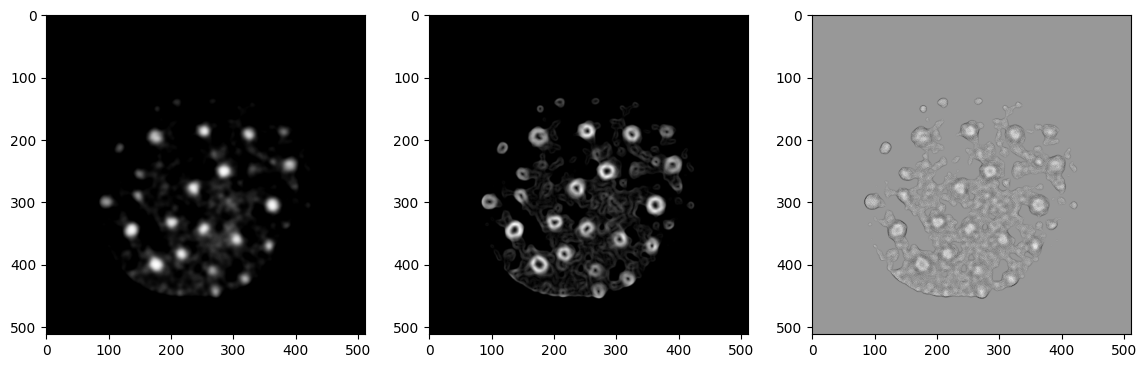

In [119]:
im = cv.imread('../example_images/ex111.tif')
im = cf.percentile_rescale(im, 0.35, 99.65)
im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
im_blur = cv.GaussianBlur(im_gray,(15,15),0)
im_blur = cf.percentile_rescale(im_blur, 0, 100)

nuc_blur = blob_nuclei(im_blur)[0]
median = int(nuc_blur.pixel_intensity_percentile(50))
nuc_mask = nuc_blur.image_masked
nuc_fill = nuc_mask.copy()
nuc_fill[nuc_fill < median] = median
nuc_fill = cf.percentile_rescale(nuc_fill, 0, 100)

edges = filters.sobel(nuc_fill)
edges = cf.percentile_rescale(edges, 0, 100)

lap = filters.laplace(nuc_fill) # ,11) ?

fig = plt.figure(figsize = (14,7))
fig.add_subplot(1, 3, 1)
plt.imshow(nuc_fill, cmap = "gray")
fig.add_subplot(1, 3, 2)
plt.imshow(edges, cmap = "gray")
fig.add_subplot(1, 3, 3)
plt.imshow(lap, cmap='gray')
plt.show()

0.00784313725490196


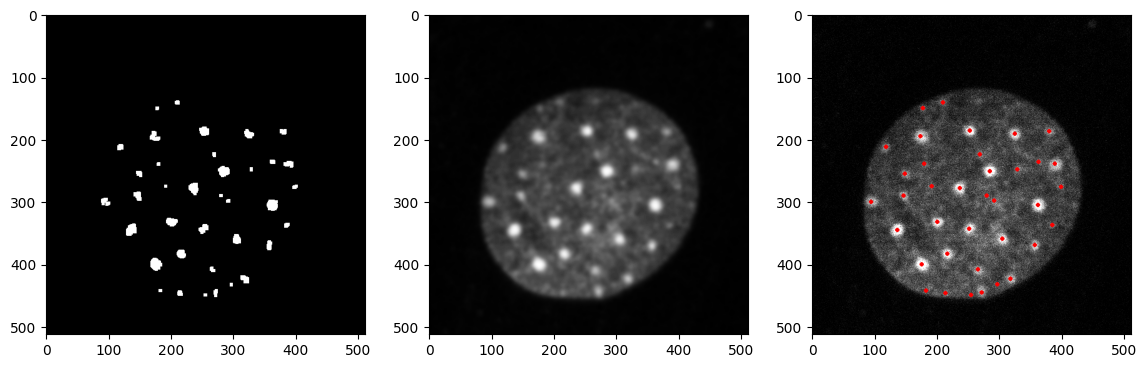

In [120]:
lap = filters.laplace(nuc_fill)
print(np.percentile(lap, 95))
lap[lap <= 0] = 0
lap[lap > 0] = 1
lap = lap.astype(np.uint8)
lap = morphology.opening(lap, morphology.square(5))
lap = morphology.remove_small_holes(lap, area_threshold=100)

contours, _ = cv.findContours(lap.astype(np.uint8),
                             cv.RETR_EXTERNAL,
                             cv.CHAIN_APPROX_NONE)

#maxima = peak_local_max(nuc_blur.image_masked, min_distance=5)
#maxima = [[x, y] for y, x in maxima]  # switch to x,y
maxima = np.array([(np.mean(contours[i], axis=0)[0].astype(int)) for i in range(len(contours))])
#contours, maxima = get_contours(nuc_blur.image_masked, thresh_min=median, thresh_step=5)
#maxima = get_maxima(nuc_blur, distance=5, threshold=0.85)

im_maxima = im.copy()
for coordinate in maxima:
    cv.circle(im_maxima, (coordinate), 2, (255,0,0), 2)
    
fig = plt.figure(figsize = (14,7))
fig.add_subplot(1, 3, 1)
plt.imshow(lap, cmap = "gray")
fig.add_subplot(1, 3, 2)
plt.imshow(im_blur, cmap = "gray")
fig.add_subplot(1, 3, 3)
plt.imshow(im_maxima, cmap='gray')
plt.show()

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [16, 18], [1, 3], [4, 5], [27, 28]]
41
37


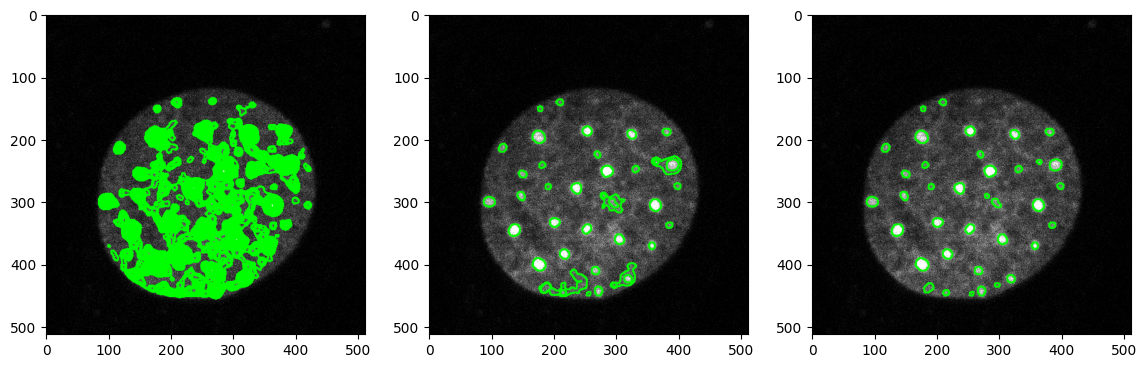

In [121]:
contours, _ = get_contours(nuc_blur.image_masked, thresh_min=median, thresh_step=5)

org_contours = organize_contours(contours, maxima)

cnts_best = best_contours(org_contours)

blobs = [bc.Blob(cnt, im_blur) for cnt in cnts_best]

cnt_filters = [['area', 10, None], # at least 0.05% of nucleus area
               ['ellipse_fit_residual_mean', None, 2]]      

blobs_filt = [blob for blob in blobs if blob_filter(blob, cnt_filters)]
    
print(len(blobs))
print(len(blobs_filt))

cont_im = im.copy()
cv.drawContours(cont_im, contours, -1, (0,255,0), 2)

cont_im2 = im.copy()
cv.drawContours(cont_im2, cnts_best, -1, (0,255,0), 2)

fig = plt.figure(figsize = (14,7))
fig.add_subplot(1, 3, 1)
plt.imshow(cont_im, cmap = "gray")
fig.add_subplot(1, 3, 2)
plt.imshow(cont_im2, cmap = "gray")
fig.add_subplot(1, 3, 3)
plt.imshow(bd.blob_im(im, blobs_filt), cmap='gray')
plt.show()

144.07060501744988


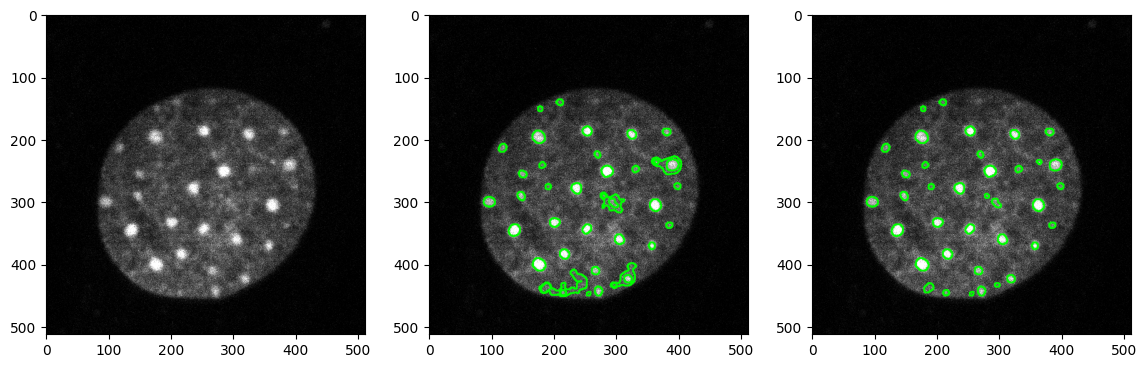

In [122]:
cnts_final = contour_remove_overlap(cnts_best)

blobs_final = [bc.Blob(cnt, im_blur) for cnt in cnts_final]

print(np.mean([blob.pixel_intensity_mean for blob in blobs_final]))

blobs_final2 = [blob for blob in blobs_final if blob.pixel_intensity_mean > 120]

fig = plt.figure(figsize = (14,7))
fig.add_subplot(1, 3, 1)
plt.imshow(im, cmap = "gray")
fig.add_subplot(1, 3, 2)
plt.imshow(cont_im2, cmap = "gray")
fig.add_subplot(1, 3, 3)
plt.imshow(bd.blob_im(im, blobs_final), cmap='gray')
plt.show()

144.07060501744988
0
[]
[]
0


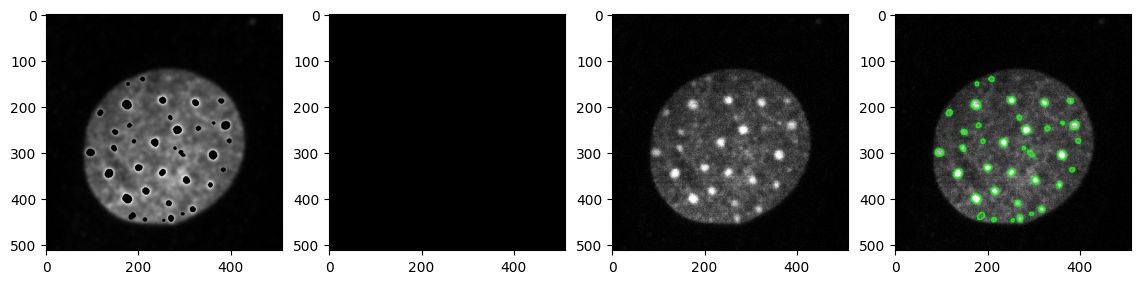

In [123]:
# change organize contours2
# find best_cnts and whole process to prevent overlap
#   maybe after determining if overlap

# maybe also get contours from opening image? to reduce the long lines

blob_mean_int = np.mean([blob.pixel_intensity_mean for blob in blobs_final])
print(blob_mean_int)

out_im = im_blur.copy()

for blob in blobs_final:
    out_im[tuple(blob.coords.T)] = 0

out_im2 = out_im.copy()
out_im2[out_im2 < blob_mean_int] = 0

out_im3 = out_im2.copy()
out_im3[out_im3 >= blob_mean_int] = 1

out_im2 = morphology.opening(out_im2, morphology.square(5))
out_im2 = morphology.area_opening(out_im2, area_threshold=50)
out_im3 = morphology.opening(out_im3, morphology.square(5))

contours, _ = cv.findContours(out_im3.astype(np.uint8),
                             cv.RETR_EXTERNAL,
                             cv.CHAIN_APPROX_NONE)

out_maxima = np.array([(np.mean(contours[i], axis=0)[0].astype(int)) for i in range(len(contours))])

def get_contours2(image, thresh_min, thresh_max=255, thresh_step=5):
    im_thresh = [cv.threshold(image, i, 255, cv.THRESH_BINARY)[1]
                 for i in range(thresh_min, thresh_max, thresh_step)]

    contours_nested = [cv.findContours(thresh,
                                       cv.RETR_EXTERNAL,
                                       cv.CHAIN_APPROX_NONE)[0]
                       for thresh in im_thresh]

    contours = [contour for contours in contours_nested
                for contour in contours]

    return contours

def organize_contours2(contours, coords): #image): #min_distance):

    # initalize empty list that will hold contours
    contour_list = [[] for pt in coords]

    # for each original contour found
    for contour in contours:
        maxima, idxs = maxima_filter(contour, coords)
        if idxs is not None and len(idxs) == 1:
            contour_list[idxs[0]].append(contour)
                
    return contour_list


contours = get_contours2(out_im2, int(blob_mean_int))
print(len(contours))

contours2 = organize_contours2(contours, out_maxima)
print([len(cnt) for cnt in contours2])

contours3 = [[] for cnts in contours2]
for i in range(len(contours2)):
    for cnt in contours2[i]:
        cnt_overlap = np.any([contour_intersect(cnt, blob.cv_contour)
                              for blob in blobs_final])
        print(cnt_overlap)
        if cnt_overlap == 0:
            contours3[i].append(cnt)

contours3 = [cnts for cnts in contours3 if len(cnts) != 0]            

print([len(cnt) for cnt in contours3])
contours4 = best_contours(contours3)
print(len(contours4))

contours5 = contour_remove_overlap(contours4)

blobs_final2 = blobs_final.copy()
for cnt in contours5:
    blobs_final2.append(bc.Blob(cnt, im_blur))

cont_out_im = im.copy()
cv.drawContours(cont_out_im, contours5, -1, (0,255,0), 2)
    
fig = plt.figure(figsize = (14,7))
fig.add_subplot(1, 4, 1)
plt.imshow(out_im, cmap = "gray")
fig.add_subplot(1, 4, 2)
plt.imshow(out_im2, cmap = "gray")
fig.add_subplot(1, 4, 3)
plt.imshow(cont_out_im, cmap = "gray")
fig.add_subplot(1, 4, 4)
plt.imshow(bd.blob_im(im, blobs_final2), cmap='gray')
plt.show()

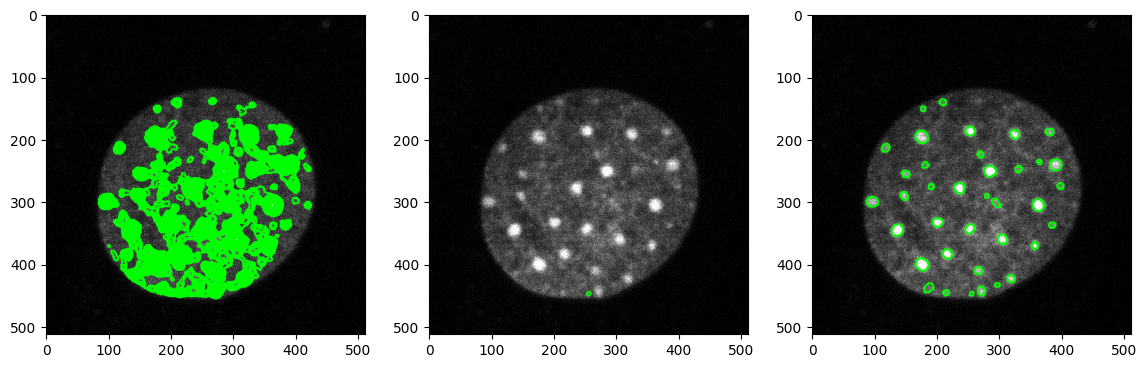

In [124]:
cont_test = im.copy()

cv.drawContours(cont_test, cnts_final[0], -1, (0,255,0), 2)
#cv.drawContours(cont_test, cnts_filt[36], -1, (0,255,0), 2)
#cv.drawContours(cont_test, cnts_filt[4], -1, (0,255,0), 2)

#print(contour_full_overlap(cnts_filt[22], cnts_filt[36]))

fig = plt.figure(figsize = (14,7))
fig.add_subplot(1, 3, 1)
plt.imshow(cont_im, cmap = "gray")
fig.add_subplot(1, 3, 2)
plt.imshow(cont_test, cmap = "gray")
fig.add_subplot(1, 3, 3)
plt.imshow(bd.blob_im(im, blobs_filt), cmap='gray')
plt.show()

In [125]:
cur_pts = [[1], [2], [3], [4], [5], [1, 2], [2, 3], [3, 4, 5]]
idxs = np.array([1, 2, 3, 4])
sc_idxs = np.array([1, 2])

qry_idxs = [x for x in idxs if x not in sc_idxs]
qry_pts = [x for x in cur_pts if len(set(qry_idxs).intersection(x)) > 0]
print(qry_pts)

[[3], [4], [2, 3], [3, 4, 5]]


In [ ]:
"""
MAYBE GET FIRST INDIVIDUAL CONTOURS AND THEN FIND MEAN PIXEL INTENSITY
IF other pixels are within 75% of mean intensity, make new contours for them
Substract out blobs from original image first
"""